In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial import HalfspaceIntersection, ConvexHull
from itertools import combinations
import networkx as nx

#### The Lemke-Howson algorithm, a deeper look

Here I had a lot of trouble understanding the algorithm, but found another great resource at https://cnl.gmu.edu/TAVRI/research/LemkeHowson.pdf, which was more intuitive, and what I follow for this section.

Here $U_1$ and $U_2$ are $(n,m)$ matricies representing the payoffs of both players. $s_1$ and $s_2$ are the strategies (probability vectors). $v_1$ and $v_2$ are constants representing the best each player can do, given the other player's strategy. Finally, $r_1$ and $r_2$ are vectors representing the gap between the reward for each action and the best action, given the other player's strategy. 

At equilibrium we have:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2 + r_1 & = v_1 \\
\text{} \quad U_2^T\cdot s_1 + r_2 & = v_2 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\text{} \quad \sum s_1 & = 1\\
\text{} \quad \sum s_2 & = 1
\end{align*}
$$

The first two equations state what we had above, that the benefit of each action plus some number equals the benefit of the best action. The third and fourth lines state that an action either has 0 probability, or it is the best action (or tied-best). The fifth and sixth state that the strategies are probabilities. We also need the condition that all variables $\geq 0$, but I have left that out for now. 

We can simplify this further by dividing the first two lines by $v_1$ and $v_2$ respectively:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2/v_1 + r_1/v_1 & = 1 \\
\text{} \quad U_2^T\cdot s_1/v_2 + r_2/v_2 & = 1 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\text{} \quad \sum s_1 & = 1\\
\text{} \quad \sum s_2 & = 1 \\
\end{align*}
$$

Defining $s_1^\prime=s_1/v_2$, $s_2^\prime=s_2/v_1$, $r_1^\prime=r_1/v_1$, and $r_2^\prime=r_2/v_2$ we can rewrite the equations above and get:

$$
\begin{align*}
\text{} \quad U_1\cdot s_2^\prime + r_1^\prime & = 1 \\
\text{} \quad U_2^T\cdot s_1^\prime + r_2^\prime & = 1 \\
\text{} \quad (v_2s_1^\prime)\cdot (v_1r_1^\prime) & = 0 \\
\text{} \quad (v_1s_2^\prime)\cdot (v_2r_2^\prime) & = 0 \\
\text{} \quad \sum s_1^\prime & = 1/v_2 \\
\text{} \quad \sum s_2^\prime & = 1/v_1 \\
\end{align*}
$$

In the third and fourth lines the constants don't matter, so we can remove them (we also do this for the condition that all variables are $\geq 0$):

$$
\begin{align*}
\text{} \quad U_1\cdot s_2^\prime + r_1^\prime & = 1 \\
\text{} \quad U_2^T\cdot s_1^\prime + r_2^\prime & = 1 \\
\text{} \quad s_1^\prime\cdot r_1^\prime & = 0 \\
\text{} \quad s_2^\prime\cdot r_2^\prime & = 0 \\
\text{} \quad \sum s_1^\prime & = 1/v_2 \\
\text{} \quad \sum s_2^\prime & = 1/v_1 \\
\end{align*}
$$

We can remove the last two equations as the utility (and equilibrium) don't depend on any scaling of the utility function. I.e., say $v_1=c_1v_1^\text{truth}$. As we are allowed any $c_1$ we can just use $c_1=1/(v_1^\text{truth}\sum s_2^\prime)$ to get $v_1=1/(\sum s_2^\prime)$. If we plug this back in the last two equations can be removed. Essentially, we are just agreeing to normalise $s_1^\prime$ and $s_2^\prime$ when outputing the actual strategies. From now on we just drop the notation and assume it's fairly clear.

$$
\begin{align*}
\text{} \quad U_1\cdot s_2 + r_1 & = 1 \\
\text{} \quad U_2^T\cdot s_1 + r_2 & = 1 \\
\text{} \quad s_1\cdot r_1 & = 0 \\
\text{} \quad s_2\cdot r_2 & = 0 \\
\end{align*}
$$

The first equation above describes $n$ different equality relationships, in $n+m$ variables. The second equation above describes $m$ different equality relationships, also in a set of $n+m$ other variables. We know in order to solve the variables in the first equation we have to set $m$ of the variables to 0, and to solve the second we need to set $n$ of the variables to 0. Equivalently, we need to choose $n$ variables in the first to be non-zero, and $m$ in the second to be non-zero. All that remains after is to test the final 2 equations are true for the result. We could do this manually by looping through all posibilities, but we can notice something useful about the choice of variables...

At this point it's helpful to encode the first equation as $\big[I\text{ }U_1\big] \big(\begin{array}{c}r_1 \\s_2 \\\end{array}\big)=\mathbf{1}$, and likewise the second as $\big[U_2\text{ }I\big] \big(\begin{array}{c}s_1 \\r_2 \\\end{array}\big)=\mathbf{1}$. 

The reason for rewriting this way is that it makes it clear that in order to satisfy the last 2 equations we need to choose different columns to be non-zero in the first and second.

Take this example:

$
\begin{array}{c|cc}
\text{} & \text{X} & \text{Y} \\
\hline
\text{X} & 3,1 & 1,0 \\
\text{Y} & 0,0 & 2,2 \\
\end{array}
$

Using the above notation we get:

$
\big[I\text{ }U_1\big]=
\begin{array}{cccc}
r_1^1 & r_1^2 & s_2^1 & s_2^2 \\
\hline
1 & 0 & 3 & 1 \\
0 & 1 & 0 & 2 \\
\end{array}
\quad
\big[U_2\text{ }I\big]=
\begin{array}{cccc}
s_1^1 & s_1^2 & r_2^1 & r_2^2 \\
\hline
1 & 0 & 1 & 0 \\
0 & 2 & 0 & 1 \\
\end{array}
$

In order for $s_1\cdot r_1 = 0$ and $s_2\cdot r_2 = 0$ we need to choose non-zero columns which don't overlap. 

For example, the solution $s_1=[\frac{2}{3},\frac{1}{3}]$,$s_2=[\frac{1}{4},\frac{3}{4}]$ corresponds to the following choice (non-zero values in red, power is the action taken):

$
\big[I\text{ }U_1\big]=
\begin{array}{cccc}
r_1^1 & r_1^2 & \textcolor{red}{s_2^1} & \textcolor{red}{s_2^2} \\
\hline
1 & 0 & 3 & 1 \\
0 & 1 & 0 & 2 \\
\end{array}
\quad
\big[U_2\text{ }I\big]=
\begin{array}{cccc}
\textcolor{red}{s_1^1} & \textcolor{red}{s_1^2} & r_2^1 & r_2^2 \\
\hline
1 & 0 & 1 & 0 \\
0 & 2 & 0 & 1 \\
\end{array}
$

We can then find all nash-equilibria by simply trying every combination of $n$ non-zero variables in the first (deriving the $m$ non-zero in the second). We just need to solve the equations for those non-zero variables, and make sure the result is valid and greater than 0. 

In [36]:
U1_I = np.array([
    [1,0,3,1],
    [0,1,0,2]
])
U2T_I = np.array([
    [1,0,1,0],
    [0,2,0,1]
])
for comb1 in list(combinations(range(4), 2)):
    comb2 = tuple(set([0,1,2,3])-set(comb1)) # notice that we just get the opposite columns here
    if not np.linalg.det(U1_I[:,comb1])==0 and not np.linalg.det(U2T_I[:,comb2])==0: # check there is a solution
        solu1 = np.zeros(4)
        solu2 = np.zeros(4)
        solu1[np.array(comb1)] = np.linalg.inv(U1_I[:,comb1]).dot(np.ones(2)) # solve for the non-zero values
        solu2[np.array(comb2)] = np.linalg.inv(U2T_I[:,comb2]).dot(np.ones(2)) # solve for the non-zero values
        if all(solu1>=0) and all(solu2>=0): # check all variables >=0
            r1 = solu1[:2]
            s2 = solu1[2:]
            s1 = solu2[:2]
            r2 = solu2[2:]
            if np.sum(s1>0) and np.sum(s2>0): # need to just check the solution (0,0) wasn't found.
                if s1.dot(r1)==0 and s2.dot(r2)==0: # check the last two equations
                    s1 = np.round(s1/np.sum(s1),2)
                    s2 = np.round(s2/np.sum(s2),2)
                    print(f"solution: s1 {s1}, s2 {s2}")

solution: s1 [0. 1.], s2 [0. 1.]
solution: s1 [1. 0.], s2 [1. 0.]
solution: s1 [0.67 0.33], s2 [0.25 0.75]


This works and will find all nash equilibria! But it is expensive. We have to do the inversion for every combination. As a final step we can speed this up a lot by turning it into a path-finding algorithm. In short we take an initial solution which is 1 clashing column away and we iteratively change the tables back and forth, switching the clashing column until we have a solution. The benefit of this approach is that we don't need to invert any matrix, as each step can be done just as a pivot operation.

Consider I have a set of $n$ and $m$ columns respectively, which between them cover at least every column except the $k$'th. If they don't cover the $k$'th there is also some $j$'th column which is in both sets. For the problem above we can draw the graph of these nodes using $k=3$. Nodes are connected if you can move between them by changing a non-zero column in one of the two tables (pivoting). Orange nodes are valid solutions, light blue ones are invalid, and gray are 1-off correct. Re-run the below if you don't get a star.

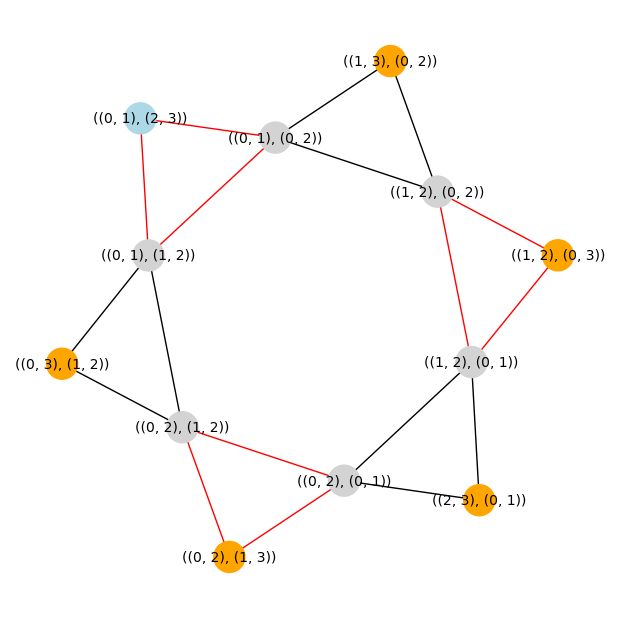

In [64]:
nodes = []
node_colors = []
for comb1 in list(combinations(range(4), 2)):
    for comb2 in list(combinations(range(4), 2)):
        all_columns = set(comb1) | set(comb2)
        if 0 in all_columns and 1 in all_columns and 2 in all_columns:
            nodes.append((comb1,comb2))
            if comb1==(0,1) and comb2==(2,3):
                node_colors.append("lightblue") # has all columns, but invalid as s1=0 and s2=0
            elif 3 in all_columns:
                node_colors.append("orange") # solution!
            else:
                node_colors.append("lightgray")
            
edges = []
edge_colors = []
for nodeA_index in range(len(nodes)):
    for nodeB_index in range(nodeA_index+1, len(nodes)):
        nodeA = nodes[nodeA_index]
        nodeB = nodes[nodeB_index]
        differences1 = len(set(nodeA[0]) ^ set(nodeB[0])) # difference in first table (IU1)
        differences2 = len(set(nodeA[1]) ^ set(nodeB[1])) # difference in second table (U2I)
        if (differences1==2 and differences2==0): # first set has changed
            edges.append((nodeA_index,nodeB_index))
            edge_colors.append("black")
        elif (differences1==0 and differences2==2): # second set has changed
            edges.append((nodeA_index,nodeB_index))
            edge_colors.append("red")

G = nx.Graph()
for i, node in enumerate(nodes):
    G.add_node(i, label=str(node))

G.add_edges_from(edges)
pos = nx.spring_layout(G)  # You can use other layouts like circular_layout
labels = nx.get_node_attributes(G, 'label')  # Fetch the node labels

plt.figure(figsize=(6, 6))
nx.draw(G, pos, with_labels=False, node_size=500, node_color=node_colors, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.show()

Notice that if we start out at the (invalid) solution $(0,1),(2,3)$ and then swap between changing the first and second set of columns back and forth we are guaranteed to arrive at a solution at some point. We are just waiting until we pivot one of the tables into that column at index 3.

For more details see https://web.stanford.edu/~saberi/lecture4.pdf.

This is a better solution because moving from 1 column to another can be done easily without redoing the inversion using the pivoting method. For more detail see the end of my notebook 2 Distributed Optimization/D - Review of linear programs, which covers pivoting a bit.